In [1]:
# Cell 1: Setup & Data Download

# (1) Install ta library if not already present
!pip install ta --quiet

# (2) Import libraries
import yfinance as yf
import pandas as pd

# (3) Download historical data for a single ticker (flat columns)
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2024-12-31")

# (4) Quick sanity checks
print("Data shape:", data.shape)
print("Columns:", data.columns.tolist())
display(data.head())


  Preparing metadata (setup.py) ... done


/tmp/ipython-input-1-1108077952.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

Data shape: (1257, 5)
Columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487839,72.526526,70.783241,71.034702,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200


In [2]:
# Cell 2 (Fixed): Data Preparation & Daily Returns

# (1) If data has MultiIndex columns (like ('Close', 'AAPL')), flatten them
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# (2) Create Daily Return (% change of Close price)
data['Daily_Return'] = data['Close'].pct_change()

# (3) Show missing values (expect 1 for Daily_Return)
print("Missing values per column:")
print(data[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']].isna().sum())

# (4) Drop the row with NaN Daily_Return
data.dropna(subset=['Daily_Return'], inplace=True)

# (5) Confirm cleanup
print("\nAfter dropping NaNs:")
print("Data shape:", data.shape)
display(data.head())


Missing values per column:
Open            0
High            0
Low             0
Close           0
Volume          0
Daily_Return    1
dtype: int64

After dropping NaNs:
Data shape: (1256, 6)


,Close,High,Low,Open,Volume,Daily_Return
Date,,,,,,
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800,-0.009722
2020-01-06,72.487839,72.526526,70.783241,71.034702,118387200,0.007968
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000,-0.004703
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200,0.016086
2020-01-09,74.864616,75.058043,74.035288,74.286741,170108400,0.021241


In [3]:
# Cell 3: Feature Engineering – Technical Indicators & Target

# (1) Install TA-Lib if needed (already done in Cell 1)
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands

# (2) Calculate indicators
data['SMA_20'] = SMAIndicator(close=data['Close'], window=20).sma_indicator()
data['EMA_14'] = EMAIndicator(close=data['Close'], window=14).ema_indicator()
data['RSI_14'] = RSIIndicator(close=data['Close'], window=14).rsi()
data['MACD'] = MACD(close=data['Close']).macd()

# (3) Bollinger Bands: upper, middle, lower
bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_upper'] = bb.bollinger_hband()
data['BB_middle'] = bb.bollinger_mavg()
data['BB_lower'] = bb.bollinger_lband()

# (4) Volume change: % change in volume day-to-day
data['Volume_Change'] = data['Volume'].pct_change()

# (5) 1-day volatility = |daily return|
data['Volatility_1D'] = data['Daily_Return'].abs()

# (6) Target variable: 5-day future volatility
data['Future_Volatility'] = (
    data['Volatility_1D']
    .rolling(window=5)
    .mean()
    .shift(-5)
)

# (7) Final cleanup – drop all rows with missing values from rolling windows
data.dropna(inplace=True)

# (8) Confirm success
print("Data after adding technical indicators and target:")
print(data.shape)
display(data.tail())


Data after adding technical indicators and target:
(1226, 16)


,Close,High,Low,Open,Volume,Daily_Return,SMA_20,EMA_14,RSI_14,MACD,BB_upper,BB_middle,BB_lower,Volume_Change,Volatility_1D,Future_Volatility
Date,,,,,,,,,,,,,,,,
2024-12-16,250.435883,250.775076,247.054041,247.393234,51694800,0.011728,238.581972,242.856125,78.747871,5.414570,253.797274,238.581972,223.366669,0.559172,0.011728,0.012007
2024-12-17,252.869995,253.219159,249.178902,249.478183,51356400,0.009720,239.851908,244.191308,80.923048,5.733044,255.382345,239.851908,224.321472,-0.006546,0.009720,0.012359
2024-12-18,247.453079,253.668083,247.143828,251.553189,56774100,-0.021422,240.838029,244.626211,64.983047,5.485108,255.652728,240.838029,226.023330,0.105492,0.021422,0.008710
2024-12-19,249.188889,251.393577,246.495389,246.904406,60882300,0.007015,241.875028,245.234568,67.211830,5.366816,255.961304,241.875028,227.788752,0.072360,0.007015,0.009955
2024-12-20,253.877594,254.386361,245.098768,247.443103,147495300,0.018816,243.170404,246.386971,72.334175,5.587006,256.655728,243.170404,229.685080,1.422630,0.018816,0.008845


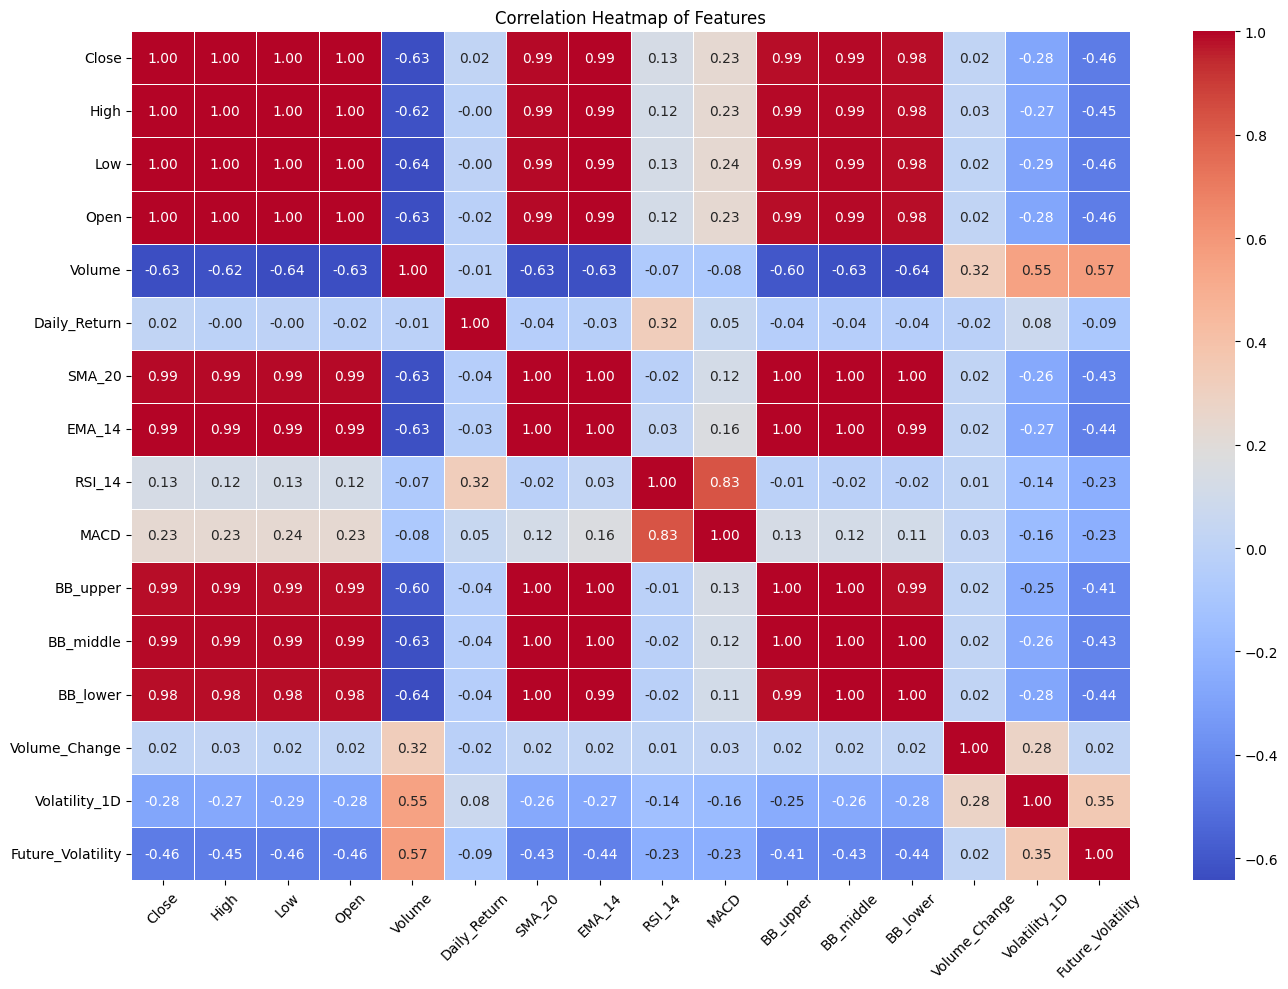

In [4]:
# Cell 4: Exploratory Data Analysis – Correlation Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# (1) Select only numeric columns for correlation
numeric_data = data.select_dtypes(include='number')

# (2) Compute correlation matrix
corr_matrix = numeric_data.corr()

# (3) Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Cell 5: ML Model – Time-Aware Features, CV & RF Pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1) Create lag features for the target (and optionally indicators)
data_lagged = data.copy()
for lag in [1, 2, 3]:
    data_lagged[f'Volatility_lag_{lag}'] = data_lagged['Future_Volatility'].shift(lag)

# 2) Drop all rows with NaNs (from rolling and lagging)
data_clean = data_lagged.dropna(subset=[
    'SMA_20','EMA_14','RSI_14','MACD',
    'BB_upper','BB_middle','BB_lower',
    'Volume_Change','Volatility_1D',
    'Future_Volatility',
    'Volatility_lag_1','Volatility_lag_2','Volatility_lag_3'
]).copy()

# 3) Define features & target
base_feats = [
    'SMA_20','EMA_14','RSI_14','MACD',
    'BB_upper','BB_middle','BB_lower',
    'Volume_Change','Volatility_1D'
]
lag_feats = [f'Volatility_lag_{lag}' for lag in [1,2,3]]
features = base_feats + lag_feats

X = data_clean[features]
y = data_clean['Future_Volatility']

# 4) Time-series train/test split (80/20)
split_idx = int(len(data_clean) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 5) Build a pipeline and time-series CV for hyperparameter tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4]
}

gscv = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# 6) Fit & select best model
gscv.fit(X_train, y_train)
best_model = gscv.best_estimator_
print("Best parameters:", gscv.best_params_)

# 7) Predict & evaluate
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__n_estimators': 200}
Mean Squared Error: 0.000005
R² Score: 0.7783


In [6]:
# Cell 6: Save the trained model

import pickle

# Save the trained model to a file
with open('volatility_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved as 'volatility_model.pkl'")

Model saved as 'volatility_model.pkl'


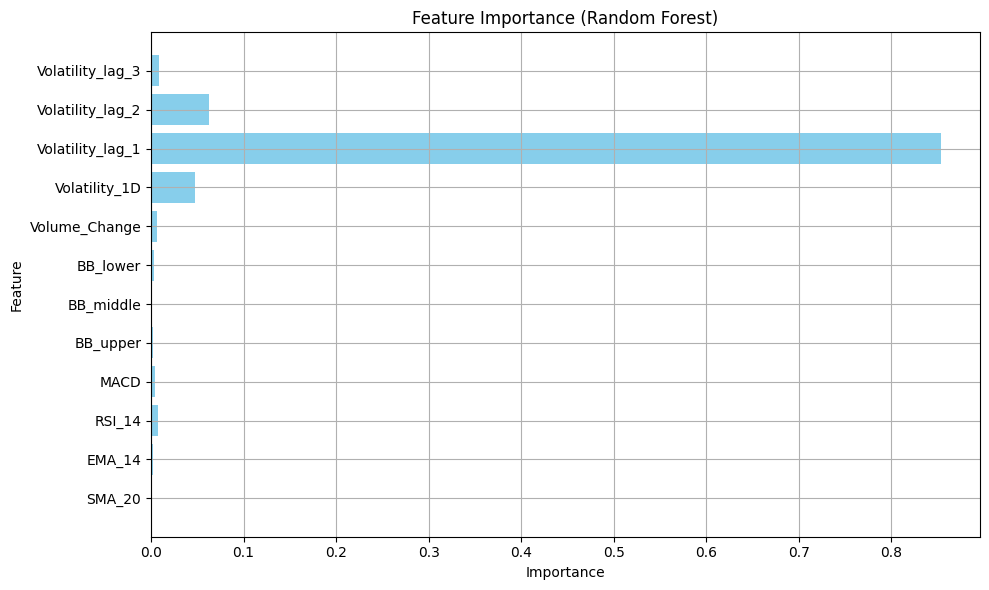

In [7]:
# Cell 7: Feature Importance Plot

import matplotlib.pyplot as plt

# Get feature importances from the trained model
# Access the random forest regressor from the pipeline
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns

# Plot the importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()